Authors:
- Brent Gerets
- Tim Boghe

# Dataset

We use a real world [credit card transfer dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?resource=download). Most of the columns do not have a meaningful name for privacy reasons. There is also a transfer amount column and a column that indicates whether the transfer is fraudulent.

The dataset is very imbalanced, only 0.172% of the transactions are fraudulent.

# Prepare data

Load in the dataset. We do not need the time column since it is not a meaningful feature (it is the time in seconds since the first transaction in the dataset).

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('creditcard.csv', sep=',')
data = data.drop("Time", axis=1)
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Split the data into train and test sets. The training set should only include non-fraud transactions since we want the model to be good at encoding and decoding these, making the fraudulous transactions stand out.

In [25]:
from sklearn.model_selection import train_test_split

non_fraud = data.loc[data["Class"] == 0]
fraud = data.loc[data["Class"] == 1]

X_train, X_test, y_train, y_test = train_test_split(non_fraud.drop("Class", axis=1), non_fraud["Class"], test_size=0.20, random_state=42)

# Add frauds back to the test set
X_test = X_test.append(fraud.drop("Class", axis=1))
y_test = y_test.append(fraud["Class"])

<ipython-input-25-a7f9b823296e>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test = X_test.append(fraud.drop("Class", axis=1))
<ipython-input-25-a7f9b823296e>:10: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_test = y_test.append(fraud["Class"])


Scale the data.

In [26]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Train and test model

Define the generator and generator optimizer.

In [27]:
import keras

generator = keras.Sequential([
    keras.layers.Dense(16, use_bias=False, input_shape=(len(X_train[0]),)),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(16),
    keras.layers.Dense(32),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(32),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(len(X_train[0]))
])
gen_optim = keras.optimizers.Adam(0.0005)

Define the discriminator and discriminator optimizer.

In [28]:
discriminator = keras.Sequential([
    keras.layers.Dense(16, use_bias=False, input_shape=(len(X_train[0]),)),
    keras.layers.LeakyReLU(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(32, use_bias=True),
    keras.layers.LeakyReLU(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1)
])
dis_optim = keras.optimizers.Adam(0.0005)

Run the model. We have to do the steps manually because we want to make a GAN.

The following steps descibe how the GAN works:
1. Let the generator generate a fake transaction starting from random input
2. Let the descriminator run on the fake transaction as well as a real transaction from the training set
3. Compute the generator loss using the output of the discriminator on the fake transaction with the target being all ones. This would mean that the discriminator is convinced the fake transaction is real.
4. Compute the discriminator loss using its output on the real transaction with the target being all ones, and its output on the fake transaction with the target being all zeros. This would mean the discriminator was able to differentiate between the real and fake transaction.
5. Calculate the new gradients using the calculated losses.
6. Apply the new gradients to the optimizer.

This repeats for a certain amount of epochs.



In [29]:
import tensorflow as tf

EPOCHS = 10
BATCH_SIZE = 256

loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)

for epoch in range(EPOCHS):
    for batch in range(len(X_train)//BATCH_SIZE):
        random_input = tf.random.uniform([BATCH_SIZE, len(X_train[0])])
        real_data = tf.cast(tf.convert_to_tensor(X_train[(batch * BATCH_SIZE):(batch * BATCH_SIZE) + BATCH_SIZE]), tf.float32)  # get real data from training set
        with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
            gen_tape.watch(random_input)
            dis_tape.watch(real_data)

            fake_data = generator(random_input, training=True)  # generate fake data
            fake_data_prob = discriminator(fake_data, training=True)  # probability that the fake data is real

            real_data_prob = discriminator(real_data, training=True)  # probability that the real data is real

            gen_loss = loss_fn(tf.ones_like(fake_data_prob), fake_data_prob)  # how good was the generator at fooling the discriminator
            dis_loss = loss_fn(tf.zeros_like(fake_data_prob), fake_data_prob) + loss_fn(tf.ones_like(real_data_prob), real_data_prob)  # how good was the discriminator at determining real data

            # get the new gradients according to the loss
            gen_grads = gen_tape.gradient(gen_loss, generator.trainable_weights)
            dis_grads = dis_tape.gradient(dis_loss, discriminator.trainable_weights)

            # apply the new gradients and optimize
            gen_optim.apply_gradients(zip(gen_grads, generator.trainable_weights))
            dis_optim.apply_gradients(zip(dis_grads, discriminator.trainable_weights))

            if batch % 100 == 0:
                print("epoch {}, batch {}: gen_loss={:.5f} dis_loss={:.5f}".format(epoch, batch, gen_loss, dis_loss))

epoch 0, batch 0: gen_loss=0.69121 dis_loss=1.65971
epoch 0, batch 100: gen_loss=0.70446 dis_loss=1.14380
epoch 0, batch 200: gen_loss=0.75416 dis_loss=1.16611
epoch 0, batch 300: gen_loss=0.81414 dis_loss=1.18511
epoch 0, batch 400: gen_loss=0.87851 dis_loss=1.51138
epoch 0, batch 500: gen_loss=0.95449 dis_loss=1.27675
epoch 0, batch 600: gen_loss=0.85767 dis_loss=1.31573
epoch 0, batch 700: gen_loss=0.81233 dis_loss=1.34649
epoch 0, batch 800: gen_loss=0.86992 dis_loss=1.25604
epoch 1, batch 0: gen_loss=0.69774 dis_loss=1.33596
epoch 1, batch 100: gen_loss=0.76871 dis_loss=1.29450
epoch 1, batch 200: gen_loss=0.70468 dis_loss=1.35937
epoch 1, batch 300: gen_loss=0.84882 dis_loss=1.25009
epoch 1, batch 400: gen_loss=0.72277 dis_loss=1.32463
epoch 1, batch 500: gen_loss=0.66473 dis_loss=1.38637
epoch 1, batch 600: gen_loss=0.74392 dis_loss=1.33642
epoch 1, batch 700: gen_loss=0.79881 dis_loss=1.29105
epoch 1, batch 800: gen_loss=0.67348 dis_loss=1.36436
epoch 2, batch 0: gen_loss=0.677

We show the precision ROC and calculate the AUC-PR since this is also the metric we used in both other exercises.

The AUC-PR is very bad, the GAN seems to have a lot of trouble improving, the losses stay about the same throughout all of the epochs.

1793/1793 [==============================] - 4s 2ms/step
0.4628863173244784


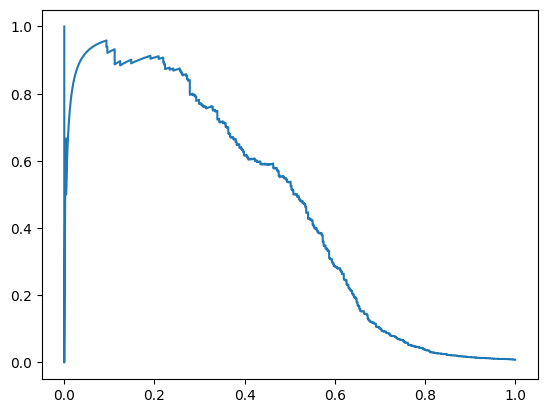

In [31]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

probabilities = [1 - i  for i in discriminator.predict(X_test)]  # take the inverse because the discriminator gives the chance that a transaction is not fake a.k.a. not an anomaly

precision, recall, _ = precision_recall_curve(y_test, probabilities)
aucpr = auc(recall, precision)
print(aucpr)

plt.plot(recall, precision)
plt.show()